In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
!pip install tensorflow

In [2]:
file_path = "/content/training.1600000.processed.noemoticon (1).csv"
df = pd.read_csv(file_path, encoding="latin-1", header=None, skiprows=1, low_memory=False)


df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [ ]:
df

,polarity,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [3]:
# Selecting relevant columns
df = df[['polarity', 'text']]
df['polarity'] = df['polarity'].replace({0: 0, 4: 1})  # Convert to binary (0: negative, 1: positive)
df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce').fillna(0).astype(int)  # Ensure labels are integers

<ipython-input-3-f32d05b2ca7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['polarity'].replace({0: 0, 4: 1})  # Convert to binary (0: negative, 1: positive)
<ipython-input-3-f32d05b2ca7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce').fillna(0).astype(int)  # Ensure labels are integers


In [4]:
# Display dataset info and first few rows
print("Dataset Information:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1048572 non-null  int64 
 1   text      1048572 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB

First 5 Rows:
   polarity                                               text
0         0  is upset that he can't update his Facebook by ...
1         0  @Kenichan I dived many times for the ball. Man...
2         0    my whole body feels itchy and like its on fire 
3         0  @nationwideclass no, it's not behaving at all....
4         0                      @Kwesidei not the whole crew 


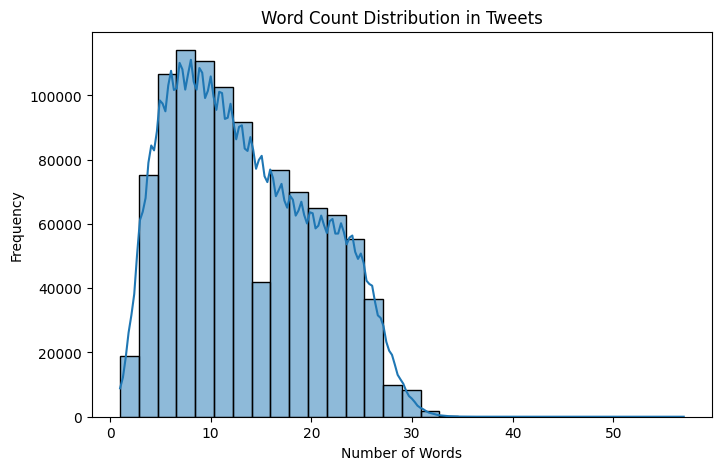

In [5]:
# Word count distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Word Count Distribution in Tweets")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

<ipython-input-6-44f4239d16c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['polarity'], palette=['red', 'green'])


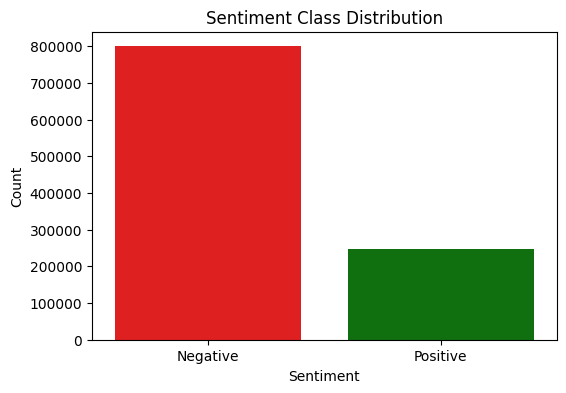

In [6]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['polarity'], palette=['red', 'green'])
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.show()

In [7]:
# Data Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=100)
y = df['polarity'].values

In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# RNN Model
rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    SimpleRNN(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 281s 11ms/step - accuracy: 0.8291 - loss: 0.3965 - val_accuracy: 0.8460 - val_loss: 0.3693
Epoch 2/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 320s 11ms/step - accuracy: 0.8465 - loss: 0.3620 - val_accuracy: 0.8495 - val_loss: 0.3541
Epoch 3/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 303s 10ms/step - accuracy: 0.8508 - loss: 0.3530 - val_accuracy: 0.8484 - val_loss: 0.3566
Epoch 4/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 262s 10ms/step - accuracy: 0.8449 - loss: 0.3644 - val_accuracy: 0.8360 - val_loss: 0.3730
Epoch 5/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 276s 11ms/step - accuracy: 0.8464 - loss: 0.3651 - val_accuracy: 0.8440 - val_loss: 0.3704


In [10]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 219s 8ms/step - accuracy: 0.8428 - loss: 0.3638 - val_accuracy: 0.8624 - val_loss: 0.3234
Epoch 2/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 276s 9ms/step - accuracy: 0.8672 - loss: 0.3123 - val_accuracy: 0.8659 - val_loss: 0.3146
Epoch 3/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 263s 9ms/step - accuracy: 0.8753 - loss: 0.2943 - val_accuracy: 0.8668 - val_loss: 0.3136
Epoch 4/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 261s 9ms/step - accuracy: 0.8836 - loss: 0.2782 - val_accuracy: 0.8651 - val_loss: 0.3163
Epoch 5/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 232s 9ms/step - accuracy: 0.8907 - loss: 0.2630 - val_accuracy: 0.8649 - val_loss: 0.3224


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
RNN Performance:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90    160130
           1       0.74      0.52      0.61     49585

    accuracy                           0.84    209715
   macro avg       0.80      0.73      0.76    209715
weighted avg       0.84      0.84      0.83    209715

LSTM Performance:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91    160130
           1       0.75      0.64      0.69     49585

    accuracy                           0.86    209715
   macro avg       0.82      0.79      0.80    209715
weighted avg       0.86      0.86      0.86    209715



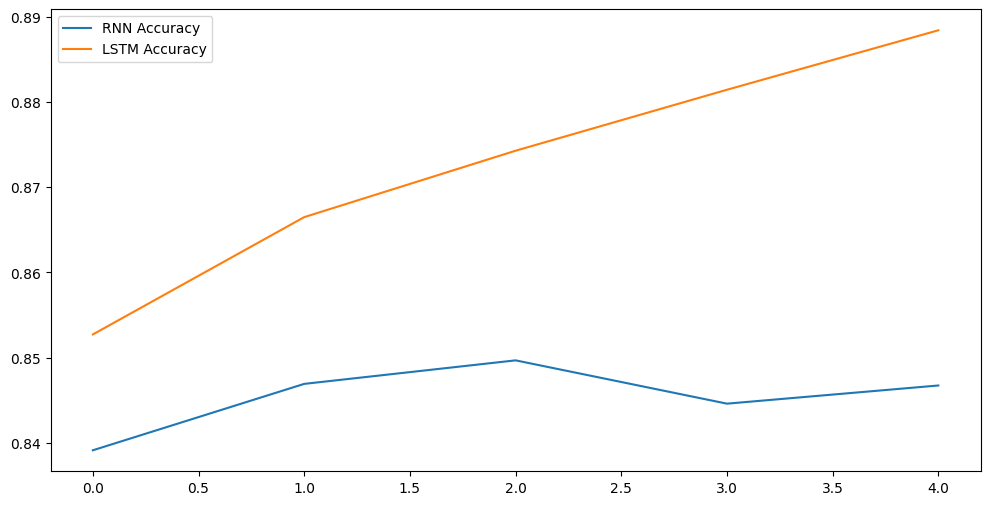

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Positive


In [11]:
# Evaluation
rnn_preds = (rnn_model.predict(X_test) > 0.5).astype(int)
lstm_preds = (lstm_model.predict(X_test) > 0.5).astype(int)

print("RNN Performance:\n", classification_report(y_test, rnn_preds))
print("LSTM Performance:\n", classification_report(y_test, lstm_preds))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='RNN Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.legend()
plt.show()

# Custom Prediction for positive
def predict_sentiment(model, text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    return "Positive" if model.predict(padded) > 0.5 else "Negative"

print(predict_sentiment(lstm_model, "I love this product!"))

In [ ]:
# Custom Prediction for negative
def predict_sentiment(model, text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    return "Positive" if model.predict(padded) > 0.5 else "Negative"

print(predict_sentiment(lstm_model, "I hate this product!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Negative


In [12]:
# Save LSTM model
lstm_model.save("lstm_model.h5")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [13]:
from google.colab import files
files.download("lstm_model.h5")
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Increased Complexicity -------------------------------------------------

 Optimized RNN Model with Dropout & Regularization

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2

rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=150),
    SimpleRNN(128, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 153s 11ms/step - accuracy: 0.8138 - loss: 0.4428 - val_accuracy: 0.8457 - val_loss: 0.3684
Epoch 2/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 198s 11ms/step - accuracy: 0.8445 - loss: 0.3747 - val_accuracy: 0.8489 - val_loss: 0.3570
Epoch 3/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 146s 11ms/step - accuracy: 0.8492 - loss: 0.3616 - val_accuracy: 0.8506 - val_loss: 0.3536
Epoch 4/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 193s 10ms/step - accuracy: 0.8510 - loss: 0.3574 - val_accuracy: 0.8528 - val_loss: 0.3556
Epoch 5/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 151s 11ms/step - accuracy: 0.8521 - loss: 0.3550 - val_accuracy: 0.8539 - val_loss: 0.3490


Optimized LSTM Model with Bidirectional Layer

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional

lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=150),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 261s 10ms/step - accuracy: 0.8288 - loss: 0.3968 - val_accuracy: 0.8484 - val_loss: 0.3587
Epoch 2/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 277s 11ms/step - accuracy: 0.8485 - loss: 0.3555 - val_accuracy: 0.8494 - val_loss: 0.3549
Epoch 3/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 322s 11ms/step - accuracy: 0.8501 - loss: 0.3532 - val_accuracy: 0.8479 - val_loss: 0.3622
Epoch 4/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 319s 10ms/step - accuracy: 0.8497 - loss: 0.3567 - val_accuracy: 0.8484 - val_loss: 0.3588
Epoch 5/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 274s 10ms/step - accuracy: 0.8507 - loss: 0.3528 - val_accuracy: 0.8456 - val_loss: 0.3596
Epoch 1/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 218s 8ms/step - accuracy: 0.8437 - loss: 0.3625 - val_accuracy: 0.8621 - val_loss: 0.3235
Epoch 2/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 214s 8ms/step - accuracy: 0.8669 - loss: 0.3116 - val_accuracy: 0.8659 - val_loss: 0.3161
Epoch 3/5
26215/26215 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accur

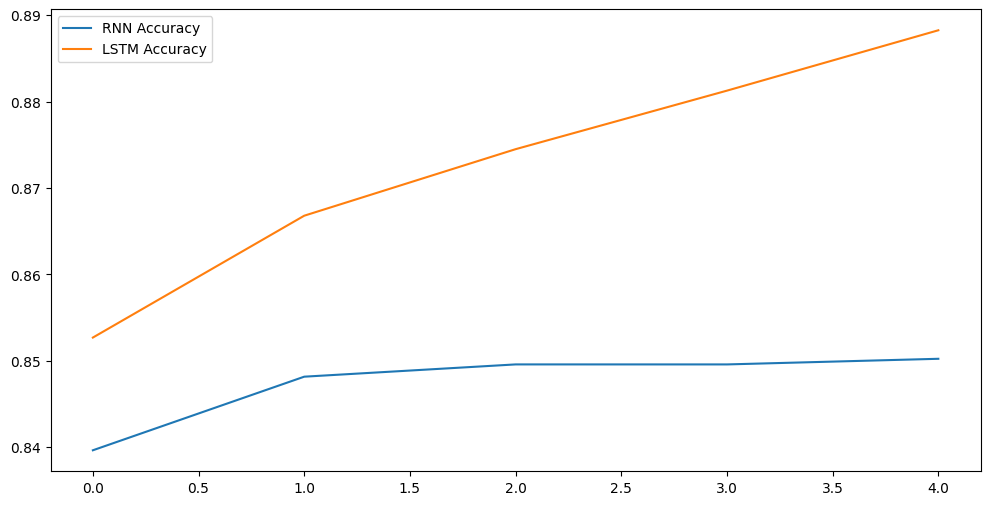

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Positive


In [ ]:
# Evaluation
rnn_preds = (rnn_model.predict(X_test) > 0.5).astype(int)
lstm_preds = (lstm_model.predict(X_test) > 0.5).astype(int)

print("RNN Performance:\n", classification_report(y_test, rnn_preds))
print("LSTM Performance:\n", classification_report(y_test, lstm_preds))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='RNN Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.legend()
plt.show()

# Custom Prediction for positive
def predict_sentiment(model, text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    return "Positive" if model.predict(padded) > 0.5 else "Negative"

print(predict_sentiment(lstm_model, "I love this product!"))